In [ ]:
# https://drive.google.com/file/d/1DlJY6ySqSZZEUgiOqL2uCkKagt5bP3MN/view?usp=share_link
!gdown --id 1DlJY6ySqSZZEUgiOqL2uCkKagt5bP3MN

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DlJY6ySqSZZEUgiOqL2uCkKagt5bP3MN
To: /content/poem_dataset.zip
100% 20.3k/20.3k [00:00<00:00, 28.7MB/s]


In [ ]:
!unzip './poem_dataset.zip'

Archive:  ./poem_dataset.zip
  inflating: poem_dataset.csv        


## **1. Import các thư viện cần thiết**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

## **2. Chuẩn bị dữ liệu**

In [ ]:
def text_normalize(text):
    text = text.lower()
    text = text.strip() 
    text = re.sub(r'[^\w\s\n]', '', text)
    text = text.replace('\n\n', '\n')
    text = '\n'.join(['<start> ' + line + ' <end>' \
                      for line in text.split('\n') \
                      if line != '' and len(line.split()) == 5])
 
    return text

In [ ]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 7
VOCAB_SIZE = 5000 

In [3]:
DATASET_PATH = './poem_dataset.csv'
df = pd.read_csv(DATASET_PATH, index_col=0)
df.head()

,title,content,source,url
0,“Cái làm ta hạnh phúc”,Cái làm ta hạnh phúc\nThực ra cũng chẳng nhiều...,"Nguồn: Châm ngôn mới (thơ), Thái Bá Tân, NXB L...",https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
1,“Chiều vừa xốp trên tay”,Chiều vừa xốp trên tay\nChợt nghe thoáng ong b...,"Nguồn: Lâm Huy Nhuận, Chiều có thật (thơ), NXB...",https://www.thivien.net/L%C3%A2m-Huy-Nhu%E1%BA...
2,“Dưới giàn hoa thiên lý...”,Dưới giàn hoa thiên lý\nMột mình anh đang ngồi...,"Nguồn: Nguyễn Nhật Ánh, Mắt biếc, NXB Trẻ, 2004",https://www.thivien.net/Nguy%E1%BB%85n-Nh%E1%B...
3,"“Đến, nhiều nơi để đến”","Đến, nhiều nơi để đến\nVề, trở lại với mình\nC...","Nguồn: Châm ngôn mới (thơ), Thái Bá Tân, NXB L...",https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
4,“Đừng bao giờ dại dột”,Đừng bao giờ dại dột\nĐem chuyện riêng của mìn...,"Nguồn: Châm ngôn mới (thơ), Thái Bá Tân, NXB L...",https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...


In [ ]:
df['content'] = df['content'].apply(lambda p: text_normalize(p))
corpus = df['content'].to_numpy()

X = []
y = []
for idx, row in df.iterrows():
    lines = row['content'].split('\n')
    lines = [line for line in lines if line != '']
    for idx in range(0, len(lines) - 1):
        input_sentence = lines[idx]
        output_sentence = lines[idx+1]

        X.append(input_sentence)
        y.append(output_sentence)

In [ ]:
for idx in range(len(X))[:1]:
    print(f'Input: {X[idx]} => {y[idx]}')

Input: <start> cái làm ta hạnh phúc <end> => <start> thực ra cũng chẳng nhiều <end>


In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='', oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
def prepare_output_sequences(y_sequences):
    y_inputs = pad_sequences(
        [y_seq[:-1] for y_seq in y_sequences], 
        maxlen=MAX_SEQ_LEN, 
        truncating='pre', 
        padding='post'
    )
    y_outputs = pad_sequences(
        [y_seq[1:] for y_seq in y_sequences], 
        maxlen=MAX_SEQ_LEN, 
        truncating='pre', 
        padding='post'
    )

    return y_inputs, y_outputs

X_sequences = tokenizer.texts_to_sequences(X)
X_padded_sequences = pad_sequences(
    X_sequences, 
    maxlen=MAX_SEQ_LEN, 
    truncating='pre', 
    padding='post'
)

y_sequences = tokenizer.texts_to_sequences(y)
y_inputs, y_outputs = prepare_output_sequences(y_sequences)

In [ ]:
n_samples = len(X_padded_sequences)
train_len = int(n_samples * 0.7)
val_len = int(n_samples * 0.2)
test_len = n_samples - train_len - val_len

# Shuffle 
np.random.seed(1)
idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X_padded_sequences = X_padded_sequences[idxs]
y_inputs = y_inputs[idxs]
y_outputs = y_outputs[idxs]

# Split the data into train, validation, and test sets
X_train_seq, y_train_input, y_train_output = X_padded_sequences[:train_len], y_inputs[:train_len], y_outputs[:train_len]
X_val_seq, y_val_input, y_val_output = X_padded_sequences[train_len:train_len+val_len], y_inputs[train_len:train_len+val_len], y_outputs[train_len:train_len+val_len]
X_test_seq, y_test_input, y_test_output = X_padded_sequences[train_len+val_len:], y_inputs[train_len+val_len:], y_outputs[train_len+val_len:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_seq, y_train_input), y_train_output)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_seq, y_val_input), y_val_output)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_seq, y_test_input), y_test_output)).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

### 3.1. Positional Encoding Layer

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

### 3.2. Self-attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

### 3.3. Cross-attention Layer

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

### 3.4. Global Self-attention Layer

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

### 3.5. Causal Self-attention Layer

In [ ]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

### 3.6. Feed-forward Network

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

### 3.7. Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

### 3.8. Transformer Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

### 3.9. Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

### 3.10. Transformer Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

### 3.11. Transformer Model

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [ ]:
N_LAYERS = 4        # Số lượng transformer encoder-decoder block
D_MODEL = 128       # Là embedding dims của một token được biểu diễn trong transformer.
D_FF = 512          # Số lượng node tại hidden layer của FeedForward Network layer
N_HEADS = 8         # Số lượng head trong multi-head attention layers
DROPOUT_RATE = 0.2  # Tỉ lệ dropout tại các layer Dropout() trong transformer

In [ ]:
transformer = Transformer(
    num_layers=N_LAYERS,
    d_model=D_MODEL,
    num_heads=N_HEADS,
    dff=D_FF,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT_RATE
)

In [ ]:
batches = train_ds.take(2)
for batch in batches:
    X_try, y_try = batch[0], batch[1]
    break

In [ ]:
output = transformer(X_try)

In [ ]:
output.shape

TensorShape([32, 7, 1471])

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2827136   
                                                                 
 decoder (Decoder)           multiple                  4938112   
                                                                 
 dense_16 (Dense)            multiple                  189759    
                                                                 
Total params: 7,955,007
Trainable params: 7,955,007
Non-trainable params: 0
_________________________________________________________________


## **4. Cấu hình mô hình**

In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 50

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98,
    epsilon=1e-9
)

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def compute_perplexity(logits, targets):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_fn(targets, logits)

    perplexity = np.exp(np.mean(loss))

    return perplexity


def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        predicted_strings.append(string_seq)
    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        target_strings.append([string_seq])  

    bleu_score = corpus_bleu(target_strings, predicted_strings)

    return bleu_score

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

## **5. Thực hiện huấn luyện**

In [ ]:
history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/50
23/23 [==============================] - 41s 311ms/step - loss: 7.2338 - masked_accuracy: 0.0130 - val_loss: 7.1170 - val_masked_accuracy: 0.1544
Epoch 2/50
23/23 [==============================] - 1s 45ms/step - loss: 7.0048 - masked_accuracy: 0.1522 - val_loss: 6.8208 - val_masked_accuracy: 0.1667
Epoch 3/50
23/23 [==============================] - 1s 45ms/step - loss: 6.7585 - masked_accuracy: 0.1667 - val_loss: 6.6655 - val_masked_accuracy: 0.1667
Epoch 4/50
23/23 [==============================] - 1s 51ms/step - loss: 6.6276 - masked_accuracy: 0.1667 - val_loss: 6.5940 - val_masked_accuracy: 0.1667
Epoch 5/50
23/23 [==============================] - 2s 80ms/step - loss: 6.5534 - masked_accuracy: 0.1667 - val_loss: 6.5405 - val_masked_accuracy: 0.1667
Epoch 6/50
23/23 [==============================] - 1s 45ms/step - loss: 6.4843 - masked_accuracy: 0.1667 - val_loss: 6.4826 - val_masked_accuracy: 0.1667
Epoch 7/50
23/23 [==============================] - 1s 45ms/step - l

## **6. Đánh giá và trực quan hóa**

In [ ]:
# Đánh giá mô hình trên tập test
test_evaluation = transformer.evaluate(test_ds)

4/4 [==============================] - 0s 17ms/step - loss: 6.5326 - masked_accuracy: 0.1901


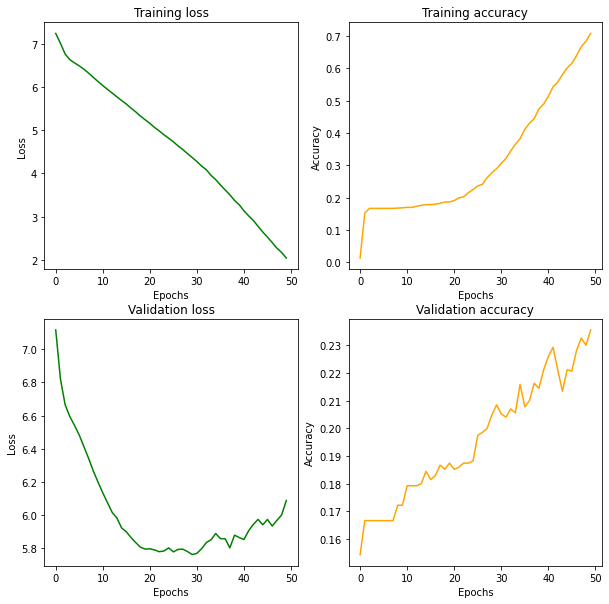

In [ ]:
# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='green') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='green') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

In [ ]:
perplexities = []
bleu_scores = []
for sample in val_ds.take(1):
    X_try, y_try = sample
    y_pred = transformer(X_try)
    batch_perplexity = compute_perplexity(y_pred, y_try)
    batch_bleu_score = compute_bleu(y_pred, y_try)

    perplexities.append(batch_perplexity)
    bleu_scores.append(batch_bleu_score)

    # print(f'Perplexity: {batch_perplexity}')
    # print(f'BLEU score: {batch_bleu_score}')

print(f'Perplexity: {sum(perplexities) / len(perplexities)}')
print(f'BLEU score: {sum(bleu_scores) / len(bleu_scores)}')

Perplexity: 1920.78857421875
BLEU score: 0.2684888158547525


## **7. Inference**

In [ ]:
def generate_text(
    generator_model, 
    tokenizer,
    input_string
    ):
    
    encoder_input_string = text_normalize(input_string) 
    encoder_input_sequence = tokenizer.texts_to_sequences([encoder_input_string])
    encoder_input_padded_sequence = pad_sequences(encoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    encoder_input_padded_sequence = np.expand_dims(encoder_input_padded_sequence, axis=0) 

    decoder_input_string = '<start>'
    decoder_input_sequence = tokenizer.texts_to_sequences([decoder_input_string])
    decoder_input_padded_sequence = pad_sequences(decoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]

    start = decoder_input_padded_sequence[0][tf.newaxis]
    end = decoder_input_padded_sequence[1][tf.newaxis]
    decoder_input_padded_sequence = np.expand_dims(decoder_input_padded_sequence, axis=0)

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start) 

    for i in tf.range(MAX_SEQ_LEN): 
        output = tf.transpose(output_array.stack())
        predictions = generator_model((encoder_input_padded_sequence, output), training=False)

        # Select the last token from the `seq_len` dimension.
        predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

        predicted_id = tf.argmax(predictions, axis=-1)

        # Concatenate the `predicted_id` to the output which is given to the
        # decoder as its input. 
        output_array = output_array.write(i+1, predicted_id[0])

        if predicted_id == end:
            break

    output = tf.transpose(output_array.stack())
    output_tokens = output.numpy()
    # The output shape is `(1, tokens)`.
    text = tokenizer.sequences_to_texts(output_tokens)[0]  # Shape: `()`.

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    generator_model([encoder_input_padded_sequence, output[:, :-1]], training=False)
    attention_weights = generator_model.decoder.last_attn_scores

    return text, output_tokens, attention_weights

In [ ]:
n_sentences = 10
results = ['hôm nay tôi đi học']
for idx in range(n_sentences + 1):
    input_str = results[idx]
    text, output_tokens, attention_weights = generate_text(
        transformer, 
        tokenizer,
        input_str
    )
    results.append(text.replace('<start>', '').replace('<end>', ''))

print('\n'.join(results))

hôm nay tôi đi học
 con mèo con mắt tôi  
 con mèo đang nhìn tôi  
 mắt trong xanh tận đáy  
 nước trong xanh tận đáy  
 anh có em mưa qua  
 như thuở xa dài không  
 em chỉ cần có anh  
 anh con trong xanh tận  
 anh có em đi qua  
 như còn mùa đông rừng  
 anh già kể đầu cúi  
